# Detecting attacks
 we will attmept to detect network attacks from netflow data

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import time
import random
import tarfile
import zipfile
#import StringIO
from IPython.display import display, Image

from sklearn.preprocessing import LabelEncoder
#from scipy import ndimage
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,MeanShift
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import linear_model, decomposition, datasets, ensemble
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score


datadir="./data/TalkingData/"

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std

In [3]:
   
def runPredict(clf,data, display=True):
    index=random.randrange(len(data))
    y_pred = clf.predict_proba(data[index].reshape(1, -1))[0]
    if display==True:
        print "for:",data[index], "\nprediction:",y_pred
    return y_pred

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return end - start
    #print "Done!\nTraining time (secs): {:.3f}".format(end - start)
    
# Predict on training set and compute F1 score
def predict_labels(clf, features, target):
    #print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    #print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target, y_pred,average='micro'),end - start #(None, 'micro', 'macro', 'weighted', 'samples')

# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):

    timeTrain=train_classifier(clf, X_train, y_train)
    predict_train,trainDelta=predict_labels(clf, X_train, y_train)
    predict_test,testDelta=predict_labels(clf, X_test, y_test)
    return predict_test,testDelta,predict_train,trainDelta,timeTrain # let's return the scores, so we can use them for comparisons

#for each data set size run and plot a train/test
def runTests(test_sizes, train_dataset,train_labels,test_dataset,test_labels, clf="", usePCA=False):
    test_f1=[]
    train_f1=[]

    for test_size in test_sizes:
        # Set up the train set for the test size
        X_train=train_dataset[:test_size]
        y_train=train_labels[:test_size]
        # Same for test
        X_test=test_dataset[-test_size:]
        y_test=test_labels[-test_size:]

 
        if clf == "":
            clf=LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,  max_iter=200,C=.1, n_jobs = -1)
            
        if usePCA ==True:
            pca=decomposition.PCA(n_components = 14*14)
            clf=Pipeline(steps=[('pca', pca), ('classifier', clf )]) # set up the clf as a pipeline ])
        # Fit model to training data
        test,testDelta,train,trainDelta,timeTrain = train_predict(clf, X_train, y_train, X_test, y_test)
        test_f1.append(test)
        train_f1.append(train)
        print ("------------------------------------------")
        print ("Training set size: {},".format(len(X_train)),"Train time (secs): {:.3f}".format(timeTrain))
        print ("F1 score for training set: {},".format(train),"Prediction time (secs): {:.3f}".format(trainDelta))
        print ("F1 score for test set: {},".format(test),"Prediction time (secs): {:.3f}".format(testDelta))

    
    print ("\n",clf)
    print("Test F1:{}".format(test_f1))
    display("Train F1:{}".format(train_f1))
    plt.plot(test_f1,label="Test F1")
    plt.plot(train_f1,label="Train F1")
    plt.legend(loc=2)
    plt.title("F1 Score per run")
    plt.show()
    
    return clf    

## Data examination

In [4]:
datadir='./'
filename='ds_1_with_fields.csv.zip'
data=loadData(datadir,filename)
data['start_time']=pd.to_datetime(data['start_time'])

display(data.info())
display(data.sample(3))



loading: ./ds_1_with_fields.csv.zip
Dataset has 337940 samples with 10 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337940 entries, 0 to 337939
Data columns (total 10 columns):
source_ip           337940 non-null object
destination_ip      337940 non-null object
start_time          337940 non-null datetime64[ns]
source_port         337940 non-null int64
destination_port    337940 non-null int64
flags               337940 non-null object
site                337940 non-null object
asn                 337940 non-null object
num_packets         337940 non-null int64
num_bytes           337940 non-null int64
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 25.8+ MB


None

,source_ip,destination_ip,start_time,source_port,destination_port,flags,site,asn,num_packets,num_bytes
72213,135.b1d10.b1d10.171,135.0777d.04511.232,1970-01-01 00:00:01.415772938,22,49418,"-A----,-A---F,-A--S-,-AP---",c9f0f,c4ca4,6,850
231552,135.0777d.04511.237,135.b1d10.d1c38.66,1970-01-01 00:00:01.415581546,33033,22,"-A----,-AP---",45c48,c4ca4,12,1008
216079,135.fa7cd.19ca1.167,135.b1d10.091d5.209,1970-01-01 00:00:01.415791009,49655,22,"----S-,-A----,-A---F,-AP---",c9f0f,c4ca4,20,2822


In [51]:
print "number of unique source_ip:", len(data.source_ip.unique())
print "mode of source_ip:", data.source_ip.mode().values[0]
print "\n"
print "number of unique destination_ip:", len(data.destination_ip.unique())
print "mode of destination_ip:", data.destination_ip.mode().values[0]
print "\n"
print "number of unique source_port:", len(data.source_port.unique())
print "mode of source_port:", data.source_port.mode().values[0]
print "\n"
print "number of unique destination_port:", len(data.destination_port.unique())
print "mode of destination_port:", data.destination_port.mode().values[0]
print "\n"
print "number of unique site:", len(data.site.unique())
print "number of unique asn:", len(data.asn.unique())
print "\n"
print "avg num_packets:", data.num_packets.mean()
print "avg num_bytes:", data.num_bytes.mean()
print "timeframe", data.start_time.min()-data.start_time.max()
print "\n"
groupbysource=data.groupby('site') 
print "source IP's per site:"
print groupbysource.apply(lambda x: len(x['source_ip'].unique()))

print "\n"
print "destination_ip's per site:"
print groupbysource.apply(lambda x: len(x['destination_ip'].unique()))
print "\n"

print "\n"
print "source_port's per site:"
print groupbysource.apply(lambda x: len(x['source_port'].unique()))
print "\n"

print "\n"
print "destination_port's per site:"
print groupbysource.apply(lambda x: len(x['destination_port'].unique()))
print "\n"

number of unique source_ip: 585
mode of source_ip: 135.0777d.04511.237


number of unique destination_ip: 594
mode of destination_ip: 135.0777d.04511.237


number of unique source_port: 27487
mode of source_port: 22


number of unique destination_port: 27480
mode of destination_port: 22


number of unique site: 3
number of unique asn: 2


avg num_packets: 1016.09807362
avg num_bytes: 867904.082035
timeframe -1 days +23:59:59.999333


source IP's per site:
site
45c48    301
c9f0f    297
e2593      1
dtype: int64


destination_ip's per site:
site
45c48    301
c9f0f    297
e2593      9
dtype: int64




source_port's per site:
site
45c48    20981
c9f0f    23087
e2593        2
dtype: int64




destination_port's per site:
site
45c48    20986
c9f0f    23079
e2593        1
dtype: int64




/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


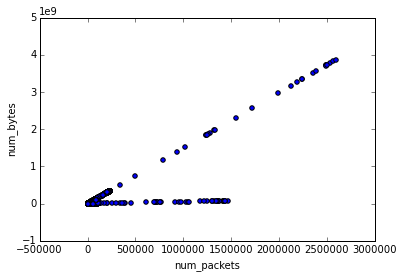

In [6]:
data.plot(kind='scatter',x='num_packets',y='num_bytes')
plt.figure(figsize=(14,10))
plt.show()
plt.close()

In [22]:
def kmeansPlusmeanshift(data):
    startingClusterSize=int(len(data)*.05)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.25).values)
    clusters=k_means.cluster_centers_
    print clusters[:15]

    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)

    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    return final_clusters

In [27]:
clusteron=data.drop(['source_ip','destination_ip','site',"asn",'flags','start_time'],1)
#display(clusteron.info())
#final_clusters=kmeansPlusmeanshift(clusteron)

# it's nice to not repeat this calculation--it's the slowest part of the job! note that it should be recalced if events changes
final_clusters_fname="final_clusters.csv"
if os.path.isfile(final_clusters_fname):    
    final_clusters=np.loadtxt(final_clusters_fname,  delimiter=",")
    print "sample clusters after kmeans:\n ",final_clusters[:15]

else:
    print "recalculating clusters..."
    final_clusters=kmeansPlusmeanshift(clusteron)
    print "sample clusters after kmeans:\n ",final_clusters[:15]
    # save the above for easier reload!
    np.savetxt(final_clusters_fname, final_clusters, delimiter=",")
print final_clusters.mean()

sample clusters after kmeans:
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.139302834823


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337940 entries, 0 to 337939
Data columns (total 11 columns):
source_ip           337940 non-null object
destination_ip      337940 non-null object
start_time          337940 non-null datetime64[ns]
source_port         337940 non-null int64
destination_port    337940 non-null int64
flags               337940 non-null object
site                337940 non-null object
asn                 337940 non-null object
num_packets         337940 non-null int64
num_bytes           337940 non-null int64
clusters            337940 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 28.4+ MB


None

,source_ip,destination_ip,start_time,source_port,destination_port,flags,site,asn,num_packets,num_bytes,clusters
0,135.b1d10.d1c38.20,135.0777d.04511.237,1970-01-01 00:00:01.415749946,22,45092,-AP---,45c48,c4ca4,6,504,0.0
1,135.0777d.04511.237,135.b1d10.13fe9.91,1970-01-01 00:00:01.415477729,45603,22,"-A----,-AP---",45c48,c4ca4,11,956,0.0
2,135.0777d.04511.237,135.b1d10.13fe9.71,1970-01-01 00:00:01.415702327,45596,22,"-A----,-AP---",45c48,c4ca4,11,956,0.0
3,135.b1d10.d1c38.119,135.0777d.04511.237,1970-01-01 00:00:01.415754478,22,50107,-AP---,45c48,c4ca4,6,504,0.0
4,135.b1d10.13fe9.56,135.0777d.04511.237,1970-01-01 00:00:01.415749597,22,45580,-AP---,45c48,c4ca4,6,504,0.0
5,135.b1d10.d1c38.72,135.0777d.04511.237,1970-01-01 00:00:01.415745508,22,51595,-AP---,45c48,c4ca4,6,504,0.0
6,135.b1d10.d1c38.126,135.0777d.04511.237,1970-01-01 00:00:01.415754317,22,38662,-AP---,45c48,c4ca4,6,504,0.0
7,135.0777d.04511.237,135.b1d10.d1c38.37,1970-01-01 00:00:01.415427333,48823,22,"-A----,-AP---",45c48,c4ca4,12,1008,0.0
8,135.0777d.04511.237,135.b1d10.d1c38.112,1970-01-01 00:00:01.415584036,51452,22,"-A----,-AP---",45c48,c4ca4,12,1008,0.0
9,135.0777d.04511.237,135.b1d10.d1c38.20,1970-01-01 00:00:01.415582789,45092,22,"-A----,-AP---",45c48,c4ca4,12,1008,0.0


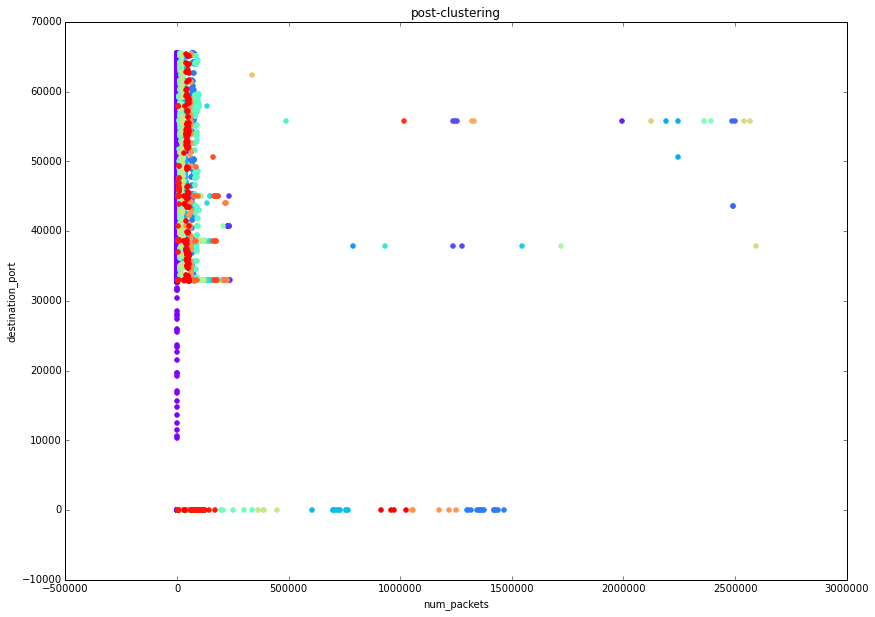

In [29]:
data['clusters']=final_clusters
display(data.info())
display(data.head(10))

numclusters=len(np.unique(final_clusters))

plt.figure(figsize=(14,10))
colors = cm.rainbow(np.linspace(0, 1, numclusters))

for cluster in range(numclusters):
    plt.scatter(data[data['clusters']==cluster]['num_packets'],
             data[data['clusters']==cluster]['destination_port'],
             color=colors[cluster])
plt.title('post-clustering')
plt.xlabel('num_packets')
plt.ylabel('destination_port')
plt.show()
plt.close()

### EOF